# 0. 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, RandomizedSearchCV

import graphviz
from sklearn.tree import export_graphviz
import time

In [2]:
print("library version check")
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", mpl.__version__)
print("sklearn: ", sklearn.__version__)

library version check
numpy:  1.23.5
pandas:  1.5.1
seaborn:  0.12.1
matplotlib:  3.6.2
sklearn:  1.1.3


In [3]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

# Iris 데이터에 RFC 적용

In [4]:
iris = pd.read_csv("../data/Iris.csv", index_col = 0)

# 학습시킬 feature와 label 분류
x_data = iris[iris.columns[1:-1]]
y_data = iris["Species"]

# 학습과 테스트 데이터 분류
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size=0.20,
                                                    random_state = 209)

In [5]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (120, 3)
y_train:  (120,)
x_test:  (30, 3)
y_test:  (30,)


# 1. RFC 

* n_estimators: Decision Tree의 개수
* max_features: feature를 랜덤하게 몇 개 뽑을 것인가
* bootstrap: False로 했을 경우 oob_score_를 계산하지 않음
* oob_score: 누락된 샘플로 모델 평가. 트리마다 평가 점수를 누적하여 평균 값 도출
* verbose: 학습하는 동안 정보 출력
* class_weight: 클래스에 dict 형태로 가중치를 줄 수도 있음. 
* max_samples: 샘플을 몇 개 뽑을 것인가. 기본적으로 부트스트랩 샘플링을 할 때 훈련 데이터의 크기 만큼 뽑지만 지정을 해 줄 수도 있음

**DT나 RFC 모델의 하이퍼 파라미터는 너무 많다.경험적으로는 아래 하이퍼 파라미터 정도 조정해 주면 되는 듯...**
* max_depth
* max_features
* min_samples_leaf
* max_leaf_nodes
* min_sampls_split

**일반적으로 max 이름을 가진 하이퍼파라미터는 감소하고, min 이름을 가진 하이퍼파라미터는 증가 시키면 모델의 성능이 향상됨**

## 1.1 OOB Score

In [6]:
model = RandomForestClassifier(n_estimators= 20, 
                               oob_score=True, 
                               max_depth = 2, 
                               random_state=209) 
model.fit(x_train, y_train)
prediction = model.predict(x_test)
print('The accuracy of the RFC is', 
      metrics.accuracy_score(prediction, y_test))

The accuracy of the RFC is 0.9333333333333333


In [7]:
model.oob_score_ 

0.9416666666666667

In [9]:
oob_score = []
estimators = [i for i in range(20, 100, 20)]

for i in estimators:
    rfc = RandomForestClassifier(n_estimators = i, 
                                  oob_score = True, 
                                  max_depth = 2, 
                                  random_state = 209)
    rfc.fit(x_train, y_train)
    oob_score.append(rfc.oob_score_)

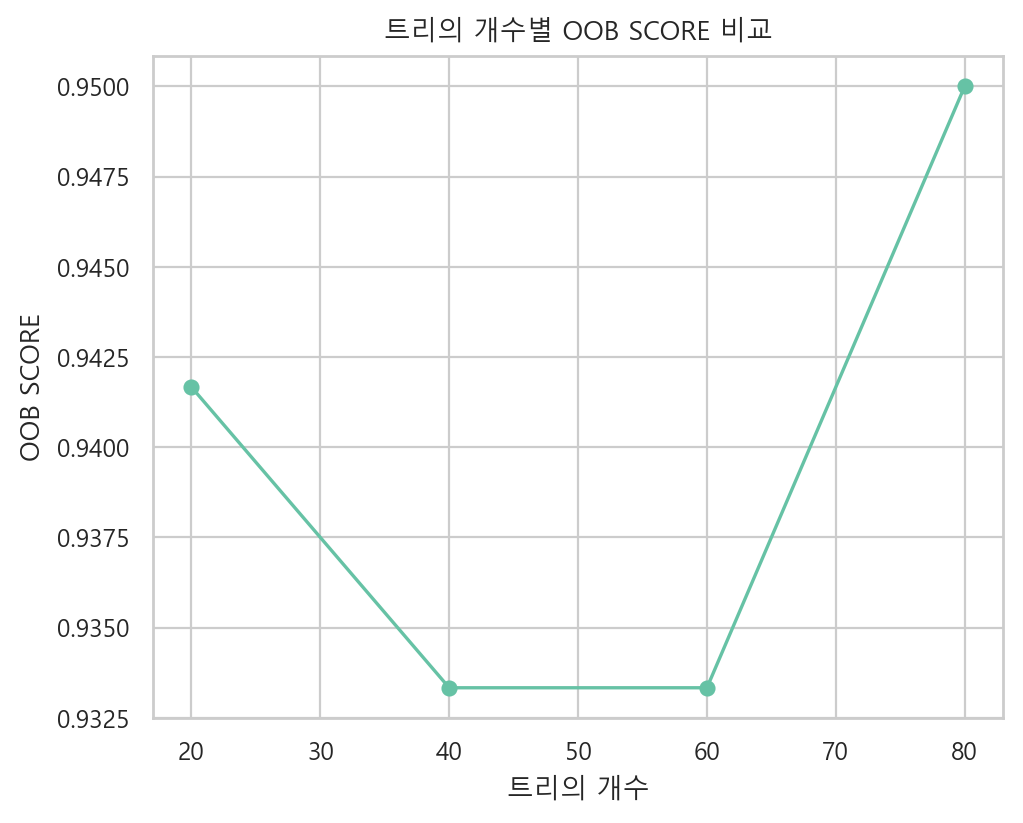

In [10]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(estimators, oob_score, marker = "o")
ax.set(xlabel = "트리의 개수",
       ylabel = "OOB SCORE",
       title = "트리의 개수별 OOB SCORE 비교");

# 2. breast_cancer 데이터에 RFC 적용

In [12]:
cancer = load_breast_cancer()

In [14]:
cancer["data"].shape

(569, 30)

In [17]:
(np.c_[cancer["data"], cancer["target"]]).shape

(569, 31)

In [19]:
cancer_df = pd.DataFrame(data = np.c_[cancer["data"], cancer["target"]],
             columns = list(cancer["feature_names"]) + ["label"]).astype({"label": "category"})

In [21]:
cancer_df["label"].value_counts()

1.0    357
0.0    212
Name: label, dtype: int64

In [29]:
## 학습시킬 feature와 label 분류해보자.
x_data = cancer_df[cancer_df.columns[:-1]]
y_data = cancer_df["label"]

In [30]:
## 학습과 테스트 데이터로 분류해보자.
## test_size=0.20, random_state = 42, stratify=y_data 설정
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size = 0.20,
                                                    random_state = 42,
                                                    stratify = y_data)

In [33]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (455, 30)
y_train:  (455,)
x_test:  (114, 30)
y_test:  (114,)


In [32]:
## RandomForestClassifier를 oob_score=True, random_state = 209

cancer_rfc = RandomForestClassifier(oob_score=True, 
                                    random_state=209) 
cancer_rfc.fit(x_train, y_train)
cancer_pred = cancer_rfc.predict(x_test)
print('The accuracy of the RFC is', 
      metrics.accuracy_score(cancer_pred, y_test))

The accuracy of the RFC is 0.956140350877193


* 나무를 몇개 만들면 좋을까?
* 나무의 개수를 변화시켜 oob_score 그래프를 그려보자

* CPU times: CPU가 코드를 수행한 시간
* Wall time: 실제 수행 시간

In [34]:
%%time
## estimators = [i for i in range(100, 300, 20)]로 하여 cancer_oob_score를 수집하시오.

oob_score = []
estimators = [i for i in range(100, 300, 20)]

for i in estimators:
    rfc = RandomForestClassifier(n_estimators = i, 
                                  oob_score = True,
                                  random_state = 209,
                                  n_jobs = -1)
    rfc.fit(x_train, y_train)
    oob_score.append(rfc.oob_score_)

CPU times: total: 8.36 s
Wall time: 12.5 s


In [35]:
%%time
#n_jobs 테스트
oob_score = []
estimators = [i for i in range(100, 300, 20)]

for i in estimators:
    rfc = RandomForestClassifier(n_estimators = i, 
                                  oob_score = True,
                                  random_state = 209,
                                  #n_jobs = -1
                                )
    rfc.fit(x_train, y_train)
    oob_score.append(rfc.oob_score_)

CPU times: total: 8.75 s
Wall time: 16.5 s


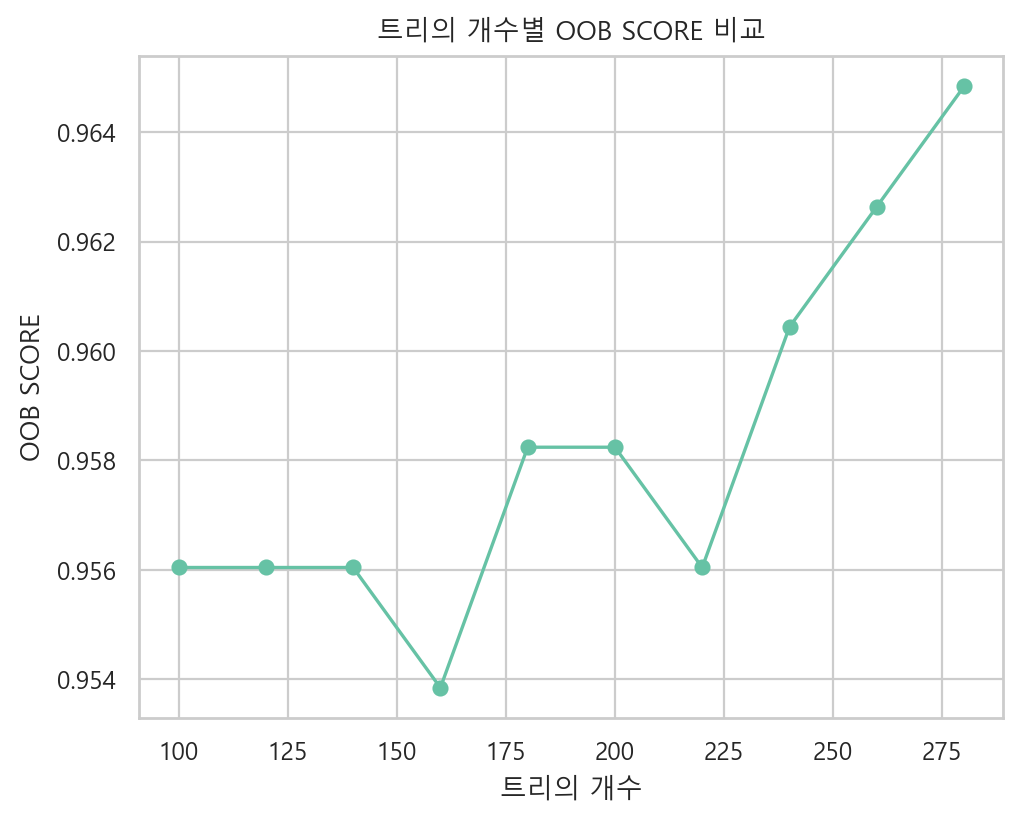

In [36]:
## 트리의 개수(n_estimator)의 변화에 따른 oob_score 그래프를 그리시오.

fig, ax = plt.subplots(figsize=(5,4))

ax.plot(estimators, oob_score, marker = "o")
ax.set(xlabel = "트리의 개수",
       ylabel = "OOB SCORE",
       title = "트리의 개수별 OOB SCORE 비교");

* GridSearchCV로 best_estimator_를 찾아보자

In [37]:
def grid_search(params, model, core):
    model_grid = GridSearchCV(model, 
                              params, 
                              cv=5, 
                              return_train_score=True,
                              n_jobs = core
                             )
    model_grid.fit(x_train, y_train)
    
    print('최상의 매개변수: ', model_grid.best_params_)
    print('훈련 데이터의 최고 정확도: ', model_grid.best_score_)
    
    model_best = model_grid.best_estimator_
    pred_best = model_best.predict(x_test)
    print('테스트 데이터의 최고 정확도: ', metrics.accuracy_score(pred_best, y_test))

* max_depth
* max_features
* min_samples_leaf
* max_leaf_nodes
* min_sampls_split

In [38]:
params = {"max_depth": [None, 2, 4],
          "max_features" : ["sqrt", "log2", None],
          "min_samples_leaf": [i for i in range(5, 10, 2)],
          "min_samples_split": [4,8]}

model = RandomForestClassifier(n_estimators = 300, 
                               oob_score = True,
                               random_state = 209)

In [39]:
%%time
# 오래걸린다!
# grid_search(params, model, -1)

최상의 매개변수:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 4}
훈련 데이터의 최고 정확도:  0.9582417582417584
테스트 데이터의 최고 정확도:  0.956140350877193
CPU times: total: 1.88 s
Wall time: 2min 24s


In [40]:
%%time
# 더 오래걸린다!
# grid_search(params, model, None)

최상의 매개변수:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 4}
훈련 데이터의 최고 정확도:  0.9582417582417584
테스트 데이터의 최고 정확도:  0.956140350877193
CPU times: total: 5min 4s
Wall time: 11min 24s


# Feature importance 

In [41]:
cancer_rfc.feature_importances_

array([0.02257308, 0.01599327, 0.04262345, 0.07988975, 0.00567124,
       0.00804386, 0.05033604, 0.09029945, 0.00290612, 0.00412492,
       0.01627716, 0.00476013, 0.00705572, 0.03173095, 0.00337517,
       0.00508395, 0.00839848, 0.00549689, 0.00380137, 0.00575204,
       0.09331334, 0.02201995, 0.15619003, 0.10022662, 0.01546444,
       0.01633817, 0.05493414, 0.11204959, 0.01115595, 0.00411475])

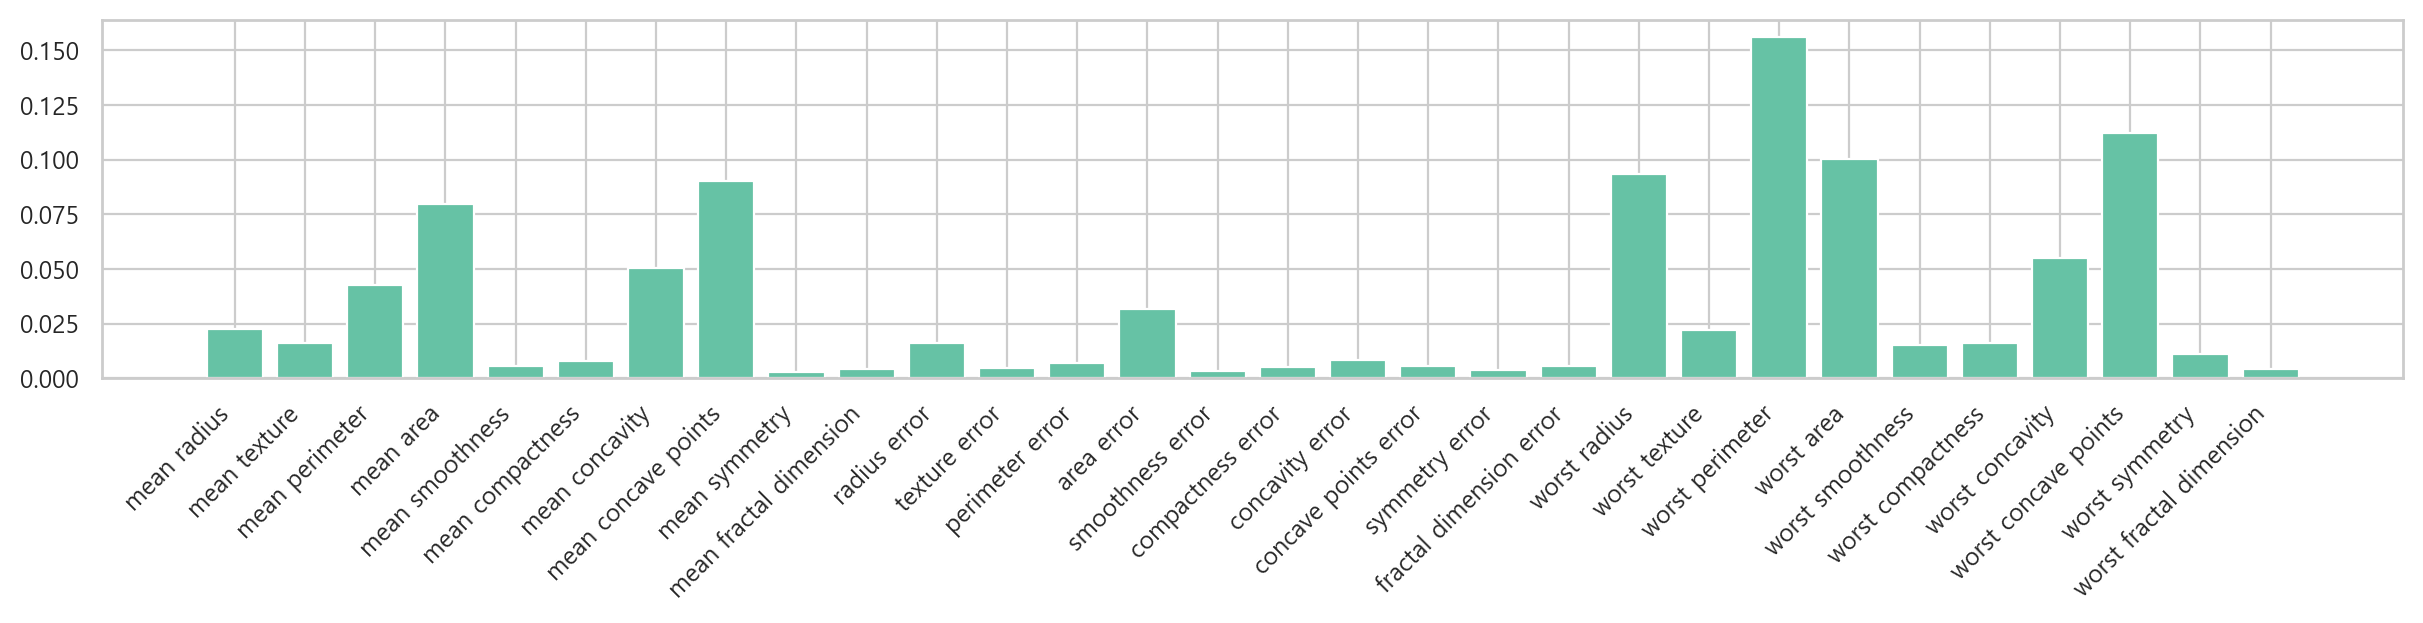

In [42]:
fig, ax = plt.subplots(figsize=(12,3))

ax.bar(x_data.columns, cancer_rfc.feature_importances_)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45);

In [43]:
feature_importance = {name: importance for name, importance in zip(x_data.columns, cancer_rfc.feature_importances_)}
feature_importance_sorted = {k: v for k, v in sorted(feature_importance.items(), 
                                                     key=lambda item: item[1], 
                                                     reverse = True)}

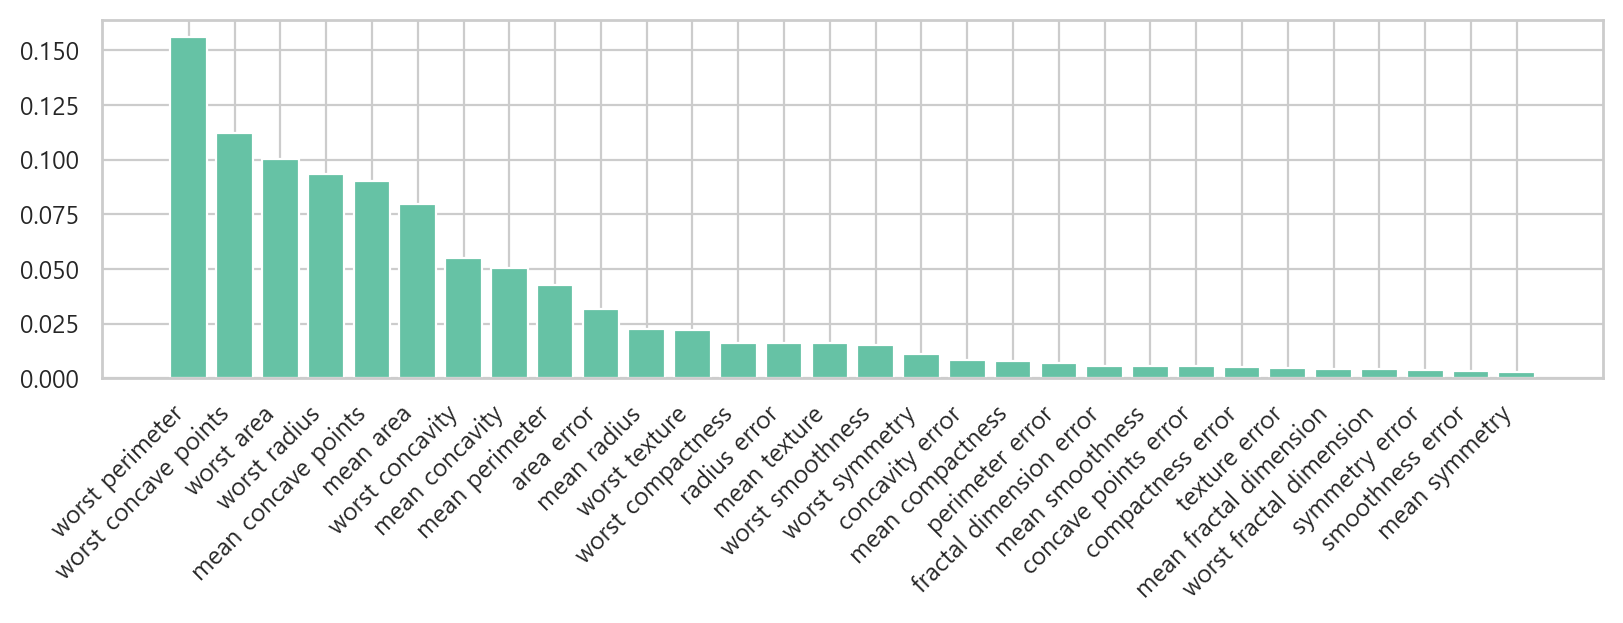

In [44]:
fig, ax = plt.subplots(figsize=(8,3))

ax.bar(feature_importance_sorted.keys(), feature_importance_sorted.values())
plt.setp(ax.get_xticklabels(), ha="right", rotation=45);

# 랜덤 포레스트를 길게 배운 이유는?

랜덤 포레스트는 
* 모델의 판단을 시각화 해서 볼 수 있고, 
* 모델이 어떤 특성을 중요하게 생각했는지 알 수 있다. 
* 따라서 어떤 데이터에서도 기준이 되는 모델로 사용할 수 있다. 
* 즉, 랜덤 포레스트 이 외에 다른 모델을 사용하고 싶다면 적어도 랜덤 포레스트 모델보다 성능이 좋아야 한다. 

그러나
* 개별 트리가 잘못된 학습을 할 경우 전체 모델에서 잘못된 결과를 도출할 수 있다. 
* 데이터가 적을 경우 과적합될 가능성이 있다.

# 240528 과제

* breast_cancer 데이터의 feature를 선택하여(30개 모두 넣지 말고) 모델의 정확도를 비교해 보자.